1.ensure that Tensorflow version is above of 2

In [1]:
    import tensorflow as tf
    print(tf.__version__)

2.8.0


2.download dataset

In [2]:
    !wget --no-check-certificate \
      https://dicoding-academy-assets.sgp1.cdn.digitaloceanspaces.com/184/messy-vs-clean-room.zip \
      -O /tmp/messy_vs_clean_room.zip

--2022-03-13 01:24:20--  https://dicoding-academy-assets.sgp1.cdn.digitaloceanspaces.com/184/messy-vs-clean-room.zip
Resolving dicoding-academy-assets.sgp1.cdn.digitaloceanspaces.com (dicoding-academy-assets.sgp1.cdn.digitaloceanspaces.com)... 205.185.216.42, 205.185.216.10
Connecting to dicoding-academy-assets.sgp1.cdn.digitaloceanspaces.com (dicoding-academy-assets.sgp1.cdn.digitaloceanspaces.com)|205.185.216.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70392746 (67M) [application/zip]
Saving to: ‘/tmp/messy_vs_clean_room.zip’

/tmp/messy_vs_clean 100%[===================>]  67.13M  5.81MB/s    in 23s     

2022-03-13 01:24:45 (2.92 MB/s) - ‘/tmp/messy_vs_clean_room.zip’ saved [70392746/70392746]



3.ekstrak zip file yg telah kita download dan tersimpan di folder /tmp 

4.define lokasi file dalam variabel

In [3]:
    # melakukan ekstraksi pada file zip
    import zipfile,os
    local_zip = '/tmp/messy_vs_clean_room.zip'
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall('/tmp')
    zip_ref.close()
     
    # define path image
    base_dir = '/tmp/images'
    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'val')

5.cek isi folder

In [5]:
    os.listdir('/tmp/images/train')

['clean', 'messy']

In [6]:
 os.listdir('/tmp/images/val')

['clean', 'messy']

6.implement ``imageDataGenerator`` to dataTraining & dataTesting.

imageDataGenerator is a function yg berguna to prepare dataTraining and dataTesting which provide
1. preprocessing data
2. pelabelan sample otomatis
3. augmentasi gambar

Image Augmentation is teknik to multiply (memperbanyak) img dataLatih by duplicate existing image with certain variation 

In [7]:
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
     
    train_datagen = ImageDataGenerator(
                        rescale=1./255,
                        rotation_range=20,
                        horizontal_flip=True,
                        shear_range = 0.2,
                        fill_mode = 'nearest')
     
    test_datagen = ImageDataGenerator(
                        rescale=1./255)

7. prepare dataLatih and validate of image set yg diload from memory through function ``flow()``  

In [8]:
    train_generator = train_datagen.flow_from_directory(
            train_dir,  # direktori data latih
            target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
            batch_size=4,
            # karena ini merupakan masalah klasifikasi 2 kelas, gunakan class_mode = 'binary'
            class_mode='binary')
     
    validation_generator = test_datagen.flow_from_directory(
            validation_dir, # direktori data validasi
            target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
            batch_size=4, # karena ini merupakan masalah klasifikasi 2 kelas gunakan class_mode = 'binary'
            class_mode='binary')

Found 192 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


8.after data ready, we will build model Convolutional Neural Network (CNN)

function of layer konvolusi is extract atribut of image.

max pooling is used to reduce img resolution sehingga training process faster

in model CNN, clasification img only focus on unique attributes yg membedakan each category. sehingga, this teknik more optimal than only use MLP model yg membedakan each category by see entire pixels in image. 

In [9]:
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

9.see model summary of model architect that we have made

In [11]:
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

from above we can explain:

1. model yg we made consist of 
- 4 Layer Convolutional & MaxPoling Layer
- 1 Flatten Layer
- 2 Dense Layer
2. in biner classification, output model is angka tunggal between 0 and 1. sehingga we set last dense layer is 1. 
3. kolom Param # contain number of parameter each layer
4. output Shape contains information output size yg dihasilkan each layer. <br><Br> if we notice, size image yg telah didefine before are (150,150) but in first convolutional layer will produce (148,148) sebanyak 32 gambar. <Br><Br> the size decrease because we using filter dengan ukuran (3,3) dengan jumlah filter sebanyak 32 filter. so, each 1 input image will produce 32 new image with size (148,148) <br><br>then, resolusi each image will diperkecil but keeping information in image by using MaxPoling layer dengan ukuran (2,2). this case will produce image output (74,74). this process also berlaku for others Convolutional  and MaxPoling layer.

5. flatten layer. output dari last MaxPoling layer that consist of 512 image with size (7,7) will be changed to array 1D (tensor 1D). this process will produce output berukuran (25088) <br><br>This output will enter to first dense layer yg have 512 neuron. so it will produce output dengan ukuran (512). <br><br>next this  output will enter to second dense layer that have 1 neuron sehingga will produce output dengan ukuran (1). output of this last layer yg digunakan as hasil akhir model for classification biner case.

10.after build CNN Model architectur. next step is do model compile using ``compile()``. in this step we also determine ``loss`` function serta  ``optimizer`.

loss function we use to compare output we want and output network. <br>loss function that we use in biner clasification is ``binary_crossentropy``

each bobot MLP disesuaikan dengan optimizer. <br>optimizer that we use in this case is ``Adam optimizer``

In [12]:
    # compile model dengan 'adam' optimizer loss function 'binary_crossentropy' 
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.optimizers.Adam(),
                  metrics=['accuracy'])

11.Last step in model development is model fitting. it is process to train model to data input and label yg bersesuaian.

in this process we insert data latih in Artificial Neural Network yg telah kita buat.

hal yg must define in this step are ``loss function`` and ``optimizer``. then we use ``fit()``

by using ``imageDataGenerator``, we doestn need to insert image and label nya. it will automaticly labeling image based on direktorinya. for instance, image in clean directory will be given label 'clean' automaticly

In [13]:
    # latih model dengan model.fit 
    model.fit(
          train_generator,
          steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
          epochs=20, # tambahkan epochs jika akurasi model belum optimal
          validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
          validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
          verbose=2)

Epoch 1/20
25/25 - 9s - loss: 0.7015 - accuracy: 0.5000 - val_loss: 0.6943 - val_accuracy: 0.5000 - 9s/epoch - 351ms/step
Epoch 2/20
25/25 - 6s - loss: 0.6942 - accuracy: 0.4300 - val_loss: 0.6928 - val_accuracy: 0.5000 - 6s/epoch - 254ms/step
Epoch 3/20
25/25 - 6s - loss: 0.6940 - accuracy: 0.4500 - val_loss: 0.6932 - val_accuracy: 0.5000 - 6s/epoch - 254ms/step
Epoch 4/20
25/25 - 7s - loss: 0.6933 - accuracy: 0.5100 - val_loss: 0.6931 - val_accuracy: 0.5000 - 7s/epoch - 263ms/step
Epoch 5/20
25/25 - 7s - loss: 0.6942 - accuracy: 0.3900 - val_loss: 0.6926 - val_accuracy: 0.5000 - 7s/epoch - 264ms/step
Epoch 6/20
25/25 - 7s - loss: 0.7014 - accuracy: 0.4900 - val_loss: 0.6930 - val_accuracy: 0.5000 - 7s/epoch - 266ms/step
Epoch 7/20
25/25 - 7s - loss: 0.6958 - accuracy: 0.5100 - val_loss: 0.6929 - val_accuracy: 0.5000 - 7s/epoch - 269ms/step
Epoch 8/20
25/25 - 7s - loss: 0.6933 - accuracy: 0.4600 - val_loss: 0.6932 - val_accuracy: 0.5000 - 7s/epoch - 262ms/step
Epoch 9/20
25/25 - 6s - 

12.Build model finished. next it is evaluation

Saving 14.png to 14.png
14.png
clean


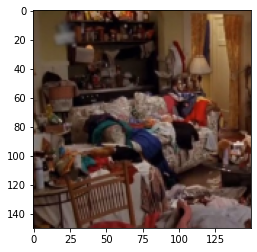

In [17]:
    import numpy as np
    from google.colab import files
    from tensorflow.keras.preprocessing import image
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    %matplotlib inline
     
    uploaded = files.upload()
     
    for fn in uploaded.keys():
     
      # predicting images
      path = fn
      img = image.load_img(path, target_size=(150,150))
     
      imgplot = plt.imshow(img)
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      images = np.vstack([x])
     
      classes = model.predict(images, batch_size=10)  
      print(fn)
      if classes==0:
       print('messy')
      else:
       print('clean')

note: i dont know. this prediction is wrong. it must be messy 